In [12]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import time
import random
np.random.seed(42)
random.seed(42)

In [16]:
df_centroids = pd.read_csv("centroids_clusters_with_region.csv")
all_centroids = df_centroids[["X", "Y"]].values
coords_with_depot = np.vstack([[0, 0], all_centroids])

distance_matrix = cdist(coords_with_depot, coords_with_depot)

def fitness(tour, dist_matrix):
    return sum(dist_matrix[tour[i], tour[i+1]] for i in range(len(tour)-1)) + dist_matrix[tour[-1], tour[0]]

def generate_greedy_initial_route(dist_matrix):
    n = len(dist_matrix)
    unvisited = set(range(1, n))
    route = [0]
    current = 0
    while unvisited:
        next_node = min(unvisited, key=lambda x: dist_matrix[current][x])
        route.append(next_node)
        unvisited.remove(next_node)
        current = next_node
    return route

def get_neighbor(route):
    new_route = route[:]
    i, j = sorted(np.random.choice(range(1, len(route)), size=2, replace=False))
    move_type = np.random.choice(["reverse", "swap", "insert"])
    if move_type == "reverse":
        new_route[i:j+1] = reversed(new_route[i:j+1])
    elif move_type == "swap":
        new_route[i], new_route[j] = new_route[j], new_route[i]
    elif move_type == "insert":
        node = new_route.pop(i)
        new_route.insert(j, node)
    return new_route

def simulated_annealing(distance_matrix, initial_route, initial_temp=20000, cooling_rate=0.9995,
                        stopping_temp=1e-4, max_iter=1000000, interval_log=50):
    current_route = initial_route[:]
    best_route = initial_route[:]
    current_cost = fitness(current_route, distance_matrix)
    best_cost = current_cost
    temperature = initial_temp

    iteration = 0
    cost_log = [best_cost] 

    while temperature > stopping_temp and iteration < max_iter:
        # Generate neighbor
        i, j = np.random.randint(1, len(current_route) - 1, size=2)
        if i > j:
            i, j = j, i
        new_route = current_route[:i] + current_route[i:j+1][::-1] + current_route[j+1:]
        new_cost = fitness(new_route, distance_matrix)

        # Acceptance criteria
        if new_cost < current_cost or np.random.rand() < np.exp((current_cost - new_cost) / temperature):
            current_route = new_route
            current_cost = new_cost
            if new_cost < best_cost:
                best_route = new_route
                best_cost = new_cost
        
        cost_log.append(best_cost)

        if iteration % interval_log == 0:
            print(f"Iterasi {iteration:4d} | Cost Saat Ini: {current_cost:.2f} | Best Cost: {best_cost:.2f} | Suhu: {temperature:.4f}")

        temperature *= cooling_rate
        iteration += 1

    print(f"Final Iterasi {iteration} | Best Cost: {best_cost:.2f}")
    return best_route, best_cost, cost_log



In [17]:
num_runs = 10
all_best_costs = []
all_best_routes = []
all_cost_logs = []
all_durations = []

for run in range(num_runs):
    np.random.seed(42 + run)
    random.seed(42 + run)
    initial_route = generate_greedy_initial_route(distance_matrix)
    start_time = time.time()
    best_route, best_cost, cost_log = simulated_annealing(distance_matrix, initial_route)
    duration = time.time() - start_time
    all_best_costs.append(best_cost)
    all_best_routes.append(best_route)
    all_cost_logs.append(cost_log)
    all_durations.append(duration)

max_len = max(len(log) for log in all_cost_logs)
cost_df = pd.DataFrame({f"Run {i+1}": log + [None] * (max_len - len(log)) for i, log in enumerate(all_cost_logs)})

# Cari index dari run dengan best cost terkecil
best_run_index = np.argmin(all_best_costs)
best_run_log = all_cost_logs[best_run_index]

# Tabel hasil best cost dan durasi
results_df = pd.DataFrame({
    "Run": [f"Run {i+1}" for i in range(num_runs)],
    "Best Cost": [f"{c:.2f}" for c in all_best_costs],
    "Durasi (detik)": [f"{t:.2f}" for t in all_durations]
})

from IPython.display import display 
display(results_df)

Iterasi    0 | Cost Saat Ini: 1917.49 | Best Cost: 1709.33 | Suhu: 20000.0000
Iterasi   50 | Cost Saat Ini: 5806.61 | Best Cost: 1709.33 | Suhu: 19506.0763
Iterasi  100 | Cost Saat Ini: 6911.51 | Best Cost: 1709.33 | Suhu: 19024.3506
Iterasi  150 | Cost Saat Ini: 7454.21 | Best Cost: 1709.33 | Suhu: 18554.5217
Iterasi  200 | Cost Saat Ini: 6753.25 | Best Cost: 1709.33 | Suhu: 18096.2958
Iterasi  250 | Cost Saat Ini: 7538.86 | Best Cost: 1709.33 | Suhu: 17649.3863
Iterasi  300 | Cost Saat Ini: 6828.85 | Best Cost: 1709.33 | Suhu: 17213.5138
Iterasi  350 | Cost Saat Ini: 7132.95 | Best Cost: 1709.33 | Suhu: 16788.4057
Iterasi  400 | Cost Saat Ini: 7922.93 | Best Cost: 1709.33 | Suhu: 16373.7961
Iterasi  450 | Cost Saat Ini: 8104.25 | Best Cost: 1709.33 | Suhu: 15969.4258
Iterasi  500 | Cost Saat Ini: 7595.92 | Best Cost: 1709.33 | Suhu: 15575.0419
Iterasi  550 | Cost Saat Ini: 7963.11 | Best Cost: 1709.33 | Suhu: 15190.3977
Iterasi  600 | Cost Saat Ini: 7912.70 | Best Cost: 1709.33 | Suh

,Run,Best Cost,Durasi (detik)
0,Run 1,1475.76,1.09
1,Run 2,1501.39,1.10
2,Run 3,1535.30,1.02
3,Run 4,1514.41,0.98
4,Run 5,1492.80,0.97
5,Run 6,1524.64,1.05
6,Run 7,1521.63,1.00
7,Run 8,1470.94,1.08
8,Run 9,1491.70,1.01
9,Run 10,1486.54,0.97


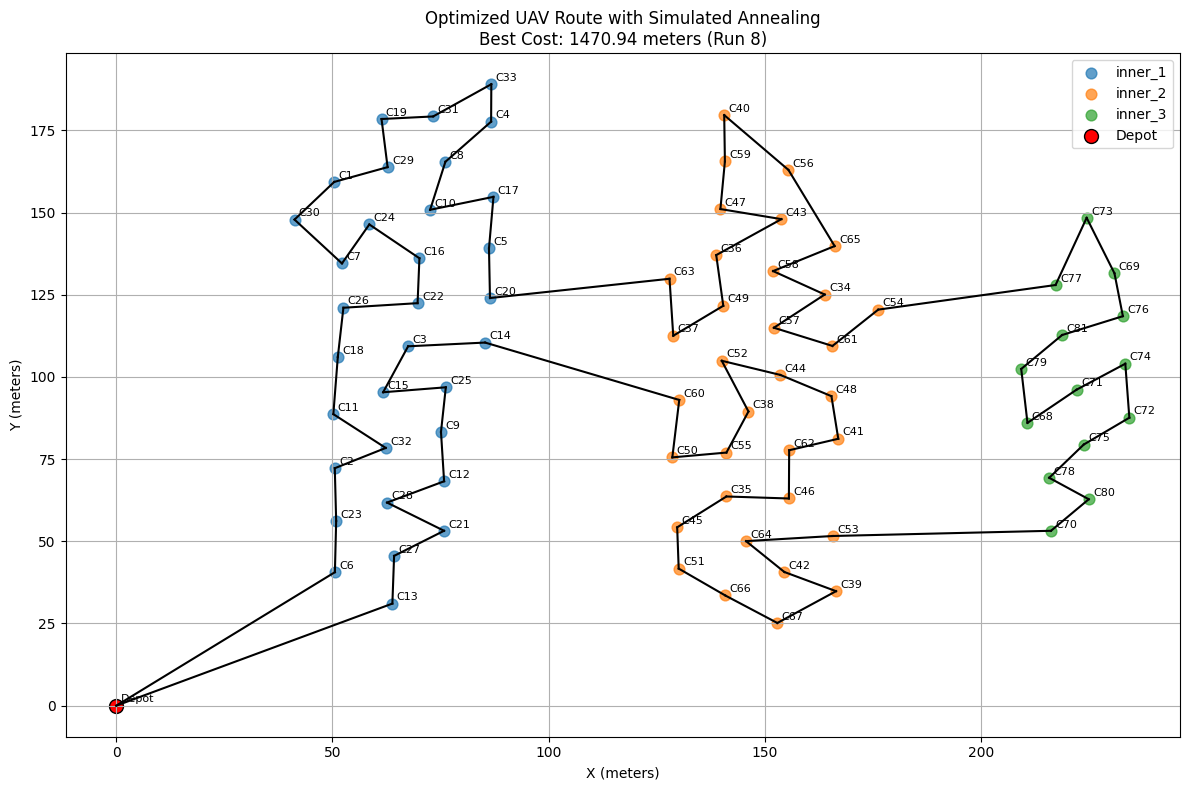

In [18]:
best_route = all_best_routes[best_run_index]
best_cost = all_best_costs[best_run_index]
plt.figure(figsize=(12, 8))

# DataFrame koordinat + region
df_coords = pd.DataFrame(coords_with_depot, columns=["X", "Y"])
df_coords["Region"] = "Depot"
df_coords.loc[1:, "Region"] = df_centroids["Region"].values  # centroid mulai index 1

# Scatter titik centroid per inner
for region in ["inner_1", "inner_2", "inner_3"]:
    region_points = df_coords[df_coords["Region"] == region]
    plt.scatter(region_points["X"], region_points["Y"], s=60, label=region, alpha=0.7)

# Scatter depot
plt.scatter(df_coords.iloc[0]["X"], df_coords.iloc[0]["Y"], s=100, c='red', edgecolor='black', label="Depot")

# Plot jalur rute UAV
for i in range(len(best_route) - 1):
    start = coords_with_depot[best_route[i]]
    end = coords_with_depot[best_route[i+1]]
    plt.plot([start[0], end[0]], [start[1], end[1]], 'k-', linewidth=1.5)
start = coords_with_depot[best_route[-1]]
end = coords_with_depot[best_route[0]]
plt.plot([start[0], end[0]], [start[1], end[1]], 'k-', linewidth=1.5)

# Label urutan traversal
for i, idx in enumerate(best_route):
    point = coords_with_depot[idx]
    label = "Depot" if idx == 0 else f"C{idx}"
    plt.annotate(label, (point[0] + 1, point[1] + 1), fontsize=8)

plt.title(f"Optimized UAV Route with Simulated Annealing\nBest Cost: {best_cost:.2f} meters (Run {best_run_index+1})")
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
